# Editing a scene

## Overview

This tutorial will show you how to modify a scene in Mitsuba 3. You might want to slightly modify a scene before (re-)rendering it for many reasons. Maybe a color is slightly off, or an object should be a bit more to its left. Such trivial modifications can easily be applied in Mitsuba.

In later tutorials, we will see that the mechanism that allows us to perform these minor edits is essential for inverse rendering applications.

<div class="admonition important alert alert-block alert-info">

🚀 **What will you learn?**

<ul>
  <li>List exposed parameters of Mitsuba objects</li>
  <li>Modify a scene</li>
</ul>

</div>

## Step 1 - Setup

Following the same steps as in #TODO (link) [Tutorial 1](...), let's import mitsuba, set the variant and load a scene from an XML file on disk.

In [1]:
import mitsuba as mi
mi.set_variant('scalar_rgb')

scene = mi.load_file("../../scenes/simple.xml")

2022-04-04 16:50:54 INFO main [xml.cpp:1296] Loading XML file "../../scenes/simple.xml" with variant "scalar_rgb"..

2022-04-04 16:50:54 DEBUG main [PluginManager] Loading plugin "plugins/srgb.so" ..

2022-04-04 16:50:54 DEBUG main [PluginManager] Loading plugin "plugins/srgb_d65.so" ..

2022-04-04 16:50:54 DEBUG wrk0 [PluginManager] Loading plugin "plugins/direct.so" ..

2022-04-04 16:50:54 DEBUG wrk1 [PluginManager] Loading plugin "plugins/independent.so" ..

2022-04-04 16:50:54 DEBUG wrk2 [PluginManager] Loading plugin "plugins/box.so" ..

2022-04-04 16:50:54 DEBUG wrk3 [PluginManager] Loading plugin "plugins/diffuse.so" ..

2022-04-04 16:50:54 DEBUG wrk7 [PluginManager] Loading plugin "plugins/ply.so" ..

2022-04-04 16:50:54 DEBUG wrk5 [PluginManager] Loading plugin "plugins/point.so" ..

2022-04-04 16:50:54 DEBUG wrk7 [PLYMesh] Loading mesh from "teapot.ply" ..

2022-04-04 16:50:54 DEBUG wrk6 [PluginManager] Loading plugin "plugins/hdrfilm.so" ..

2022-04-04 16:50:54 DEBUG wrk5 [PluginManager] Loading plugin "plugins/uniform.so" ..

2022-04-04 16:50:54 DEBUG wrk7 [PLYMesh] "teapot.ply": read 2256 faces, 1177 vertices (54 KiB in 10ms)

2022-04-04 16:50:54 DEBUG wrk8 [PluginManager] Loading plugin "plugins/perspective.so" ..

2022-04-04 16:50:54 DEBUG wrk7 [PLYMesh] "teapot.ply": computed vertex normals (took 7ms)

2022-04-04 16:50:54 INFO main [Scene] Embree ready. (took 22ms)

2022-04-04 16:50:54 INFO main [xml.cpp:1356] Done loading XML file "../../scenes/simple.xml" (took 83ms).

Let's also quickly render this scene to know what we're exactly dealing with.

2022-04-04 16:50:54 INFO main [SamplingIntegrator] Starting render job (256x256, 128 samples, 32 threads)

2022-04-04 16:50:56 INFO main [SamplingIntegrator] Rendering finished. (took 1.788s)

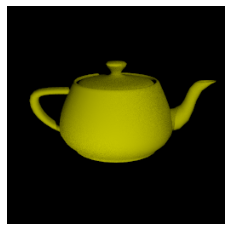

In [2]:
original_image = mi.render(scene, spp=128)

import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(original_image ** (1.0 / 2.2));

## Step 2 - Access scene parameters

The `mi.traverse` function takes any Mitsuba object as input and returns a `mi.SceneParameters` object, with a similar API to a normal Python `dict`. This dictionnary holds all parameters that are exposed by the input object and its children. Therefore, when given a scene as input, this function will return the parameters of all objects that are in the scene.

A `mi.SceneParameters` object can be printed in order to look at the keys of the various parameters available in our scene graph.

In [3]:
params = mi.traverse(scene)
params

SceneParameters[
  ----------------------------------------------------------------------------------------
  Name                                 Flags    Type            Parent
  ----------------------------------------------------------------------------------------
  sensor.near_clip                              float           PerspectiveCamera
  sensor.far_clip                               float           PerspectiveCamera
  sensor.shutter_open                           float           PerspectiveCamera
  sensor.shutter_open_time                      float           PerspectiveCamera
  sensor.x_fov                                  float           PerspectiveCamera
  sensor.to_world                               Transform4f     PerspectiveCamera
  teapot.bsdf.reflectance.value        ∂        Color3f         SRGBReflectanceSpectrum
  teapot.vertex_count                           int             PLYMesh
  teapot.face_count                             int             PLYMesh
  teap

As you can see, the first level of our scene graph is composed of 4 objects: the camera (`sensor`), the teapot mesh (`teapot`), and a couple lights (`light1` and `light2`). Some of those objects point to nested child objects, like `teapot.bsdf`.

The names of the objects in the scene graph are defined by the id of those objects in the scene file. Object's parameters such as `teapot.vertex_positions` or `sensor.far_clip` are documented in their respective parent's plugin documentation: #TODO (links) [PLYMesh]() and [PerspectiveCamera](). All of the plugins in the documentation list which of their parameters are exposed, as well as all of the input parameters they can take in the scene description. If you wish to modifiy a plugin's parameter, and that parameter is not exposed with `mi.traverse`, you still have the option to modify the scene file directly. `mi.traverse` is merely a convenience function that allows you to modify scene objects in-place, rather than reconstructing the entire scene.

Individual scene parameters can be accessed with the `__getitem__` operator, providing the `key` corresponding to the parameter. Let's read the values of a few of the scene parameters.

In [4]:
print('sensor.near_clip:             ',  params['sensor.near_clip'])
print('teapot.bsdf.reflectance.value:',  params['teapot.bsdf.reflectance.value'])
print('light1.intensity.value:       ',  params['light1.intensity.value'])

sensor.near_clip:              0.009999999776482582
teapot.bsdf.reflectance.value: [0.8999999761581421, 0.8999999761581421, 0.0]
light1.intensity.value:        [100.0, 100.0, 100.0]


## Step 3 - Edit the scene

Let's simply tint the color of both light sources. Similarly to a Python `dict`, parameters can be modified in-place using the `__setitem__` operator. Internally, the `mi.SceneParameters` object will record every update written to it. Once all updates were performed, it is necessary to call the `mi.SceneParameters.update` method to properly apply the desired changes.

Certain objects might need to be notified if one or more of its children have been updated. Using `mi.SceneParameters.update` will also propagate all updates through the dependency graph, and perform all necessary updates to the parent objects. For instance, a change to the vertex position buffer of a mesh in the scene will trigger the recomputation of the Embree/Optix BHV.

In [5]:
# Give a red tint to light1 and a green tint to light2
params['light1.intensity.value'] *= [1.5, 0.2, 0.2]
params['light2.intensity.value'] *= [0.2, 1.5, 0.2]

# Apply updates
params.update()

We can now easily compare the rendered images using `matplotlib`. 

2022-04-04 16:50:57 INFO main [SamplingIntegrator] Starting render job (256x256, 128 samples, 32 threads)

2022-04-04 16:51:01 INFO main [SamplingIntegrator] Rendering finished. (took 3.5s)

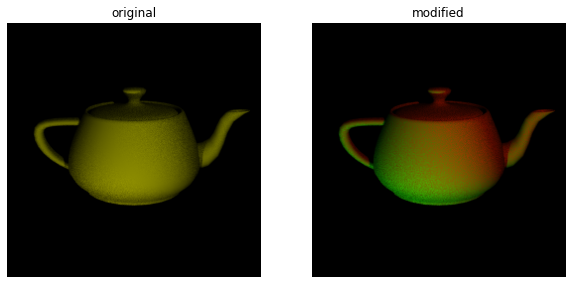

In [6]:
modified_image = mi.render(scene, spp=128)
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1,2,1).imshow(original_image); plt.axis('off'); plt.title('original')
fig.add_subplot(1,2,2).imshow(modified_image); plt.axis('off'); plt.title('modified');

### *Reference API*

- [<code>mitsuba.traverse</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.set_variant)
- [<code>mitsuba.SceneParameters</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.load_file)